<a href="https://colab.research.google.com/github/NicholasBaraghini/Ball-and-Beam-system-Optimal-Control/blob/main/OPTCON_Grp21_Ball_and_Beam_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OPTIMAL CONTROL EXAM PROJECT**

 Group 21:
   - Baraghini Nicholas 0000984041 
   - Curto Fabio
   - Iadarola Federico

In [49]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

import system_dynamic as sd
import optcon as opt
import cost_function
import matplotlib.pyplot as plt_
import Reference_Trajectory as RT
import h5py
%matplotlib widget

import visualization as visu

**TRAJECTORY TRACKING** (Task 3)

In [50]:
# PARAMETERS SETTING

max_iterations = 10;
STOP_ITER = 1E-6; #Stop Iteration descent threshold

#step_size = 0.1;
cc = 0.05
beta = 0.5

nx = 4  # nmumber of states
nu = 1  # number of inputs


params = {'tf':10,
          'dt':0.001,   # Step size - Forward Euler method
          'gg':9.81,    # gravitational acceleration [m/s^2]
          'mm': 6.4352E-5,    # ball mass [kg]
          'rr':0.0127,   # ball radius [m]
          'ii': 3.2691E-8, # ball inertia [kg*m^2]
          'II':0.0083,   # beam inertia [kg*m^2]
          'LL':1,        # beam lenght [m]
          'dim_X': nx,
          'dim_U': nu,
          'QQ':np.array([[300, 0, 0 , 0],
                        [ 0 ,1, 0 , 0],
                        [ 0 , 0,100, 0],
                        [ 0 , 0, 0 ,1]]),
          'RR':1,
          'QQ_T':np.array([[100, 0, 0 , 0],
                          [ 0 ,0, 0 , 0],
                          [ 0 , 0,100, 0],
                          [ 0 , 0, 0 ,0]]),
          'QQ_track':np.array([[100, 0, 0 , 0],
                               [ 0 ,1, 0 , 0],
                               [ 0 , 0,100, 0],
                               [ 0 , 0, 0 ,1]]),
          'RR_track':1,
          'QQ_track_T':np.array([[100, 0, 0 , 0],
                                [ 0 , 10, 0 , 0],
                                [ 0 , 0,100, 0],
                                [ 0 , 0, 0 ,10]])
              }

TT = int(params['tf']/params['dt']); # rounding down of the time span divided in time in number oof time intervals


**Reference Definition** \
Step reference change between two equilibria

In [51]:
# REFERENCE DEFINITION
qs_trajectory = True          #flag for arbitrary qs reference trajectory
trajectory = False             #flag for arbitrary cubic reference trajectory
step = False                   #flag for step reference
multiple_step = False          #flag for multiple step reference
if not (trajectory + step + multiple_step + qs_trajectory):
    print('WARNING: no shape to follow selected')
    step = True
    print('default selected')

if qs_trajectory:
    L = params['LL']
    tt = np.array([0, 0.8, 1.5 , 3, 4.5, 5, 5.8, 6.5, 8, 9.5, 10])
    xx_interpolate = np.array([0, 0.3*L/2, 0.6*L/2, 0.95*L/2, 0.2*L/2, 0, -0.3*L/2, -0.6*L/2, -0.95*L/2, -0.2*L/2,0]) #w aypoints to be interpolated
    plot = 1    #flag for plot of generated reference

if qs_trajectory:
    xx_ref, uu_ref  = RT.Spline_Ref(xx_interpolate, tt,TT, params, plot).values() #generate cubic spline
    init_pos = xx_ref[0,0] # initial position
    init_inp = uu_ref[0,0] # initial input
elif step:
    ref_pos = -0.8*0.5*params['LL'] # ball reference position on the beam [m]
    init_pos = 0.5*0.5*params['LL'] # ball initial position on the beam [m]
    ref_inp = params['mm']*params['gg']*ref_pos; # input reference torque at reference pos ref_pos
    init_inp = params['mm']*params['gg']*init_pos # input reference torque at init position
    # state reference definition:
    xx_ref = np.zeros((nx,TT))
    xx_ref[0,0:round(TT/2)] = init_pos
    xx_ref[0,round(TT/2):TT] = ref_pos


    # input reference definition
    uu_ref = np.zeros((nu,TT))
    uu_ref[0,0:round(TT/2)] = init_inp
    uu_ref[0,round(TT/2):TT] = ref_inp
elif multiple_step:
    init_pos = 0.5*0.5*params['LL'] # ball initial position on the beam [m]
    ref_pos1 = -0.8*0.5*params['LL'] # ball reference position 1 on the beam [m]
    ref_pos2 =  0.8*0.5*params['LL'] # ball reference position 2 on the beam [m]
    ref_pos3 = 0*0.5*params['LL'] # ball reference position 3 on the beam [m]

    init_inp = params['mm']*params['gg']*init_pos # input reference torque at init position
    ref_inp1 = params['mm']*params['gg']*ref_pos1; # input reference torque at reference pos ref_pos1
    ref_inp2 = params['mm']*params['gg']*ref_pos2; # input reference torque at reference pos ref_pos2
    ref_inp3 = params['mm']*params['gg']*ref_pos3; # input reference torque at reference pos ref_pos3


    # state reference definition:
    xx_ref = np.zeros((nx,TT))
    xx_ref[0,0:round(TT/4)] = init_pos
    xx_ref[0,round(TT/4):round(TT/2)] = ref_pos1
    xx_ref[0,round(TT/2):round(3*TT/4)] = ref_pos2
    xx_ref[0,round(3*TT/4):TT] = ref_pos3

    # input reference definition
    uu_ref = np.zeros((nu,TT))
    uu_ref[0,0:round(TT/4)] = init_inp
    uu_ref[0,round(TT/4):round(TT/2)] = ref_inp1
    uu_ref[0,round(TT/2):round(3*TT/4)] = ref_inp2
    uu_ref[0,round(3*TT/4):TT] = ref_inp3
elif trajectory:
    path = 'trajectory_points/x'
    xx_ref = np.zeros((nx,TT))
    for i in range(1,5):
        path_dummy = path + str(i) +'.mat'
        name_dummy = 'x' + str(i)
        mat = h5py.File(path_dummy)
        data = mat.get(name_dummy)
        data = np.array(data).T
        xx_ref[i-1,:] = data[1, 0:TT]
        print('data about state loaded')
        init_pos = xx_ref[0,0]

    uu_ref = np.zeros((nu,TT))
    mat = h5py.File('trajectory_points/reference.mat')
    data = mat.get('torque')
    data = np.array(data).T
    uu_ref[0,:] = data[1,0:TT]
    print('data about input loaded')
    init_inp = uu_ref[0,0]

xx_init = np.zeros((nx,1))
xx_init[0] = init_pos # initial state


**OPTIMIZATION LOOP**

In [52]:
#Task two: optimal trajectory generation
# Initializations
xx = np.zeros((nx,TT,max_iterations)) # state tensor
xx[0,0,:] = init_pos # init ball position
uu = np.zeros((nu,TT,max_iterations)) # input tensor
uu[0,0,:] = init_inp  # init torque input

cost = np.zeros((max_iterations,1)) # cost function values memory

descent = np.zeros((max_iterations,1)) # descent vector

#initialize trajectory
kk = 0
for tt in range(0,TT-1):

    uu_tk = uu[:, tt:tt + 1, kk:kk + 1] # shape (1,1,1)
    uu_ref_tt = uu_ref[:, tt:tt + 1] # shape (1,1)
    xx_tk = xx[:, tt:tt + 1, kk:kk + 1] # shape (4,1,1)
    xx_ref_tt = xx_ref[:, tt:tt + 1] # shape (4,1)

    cost_temp = cost_function.Stage_Cost(xx_tk, uu_tk, xx_ref_tt, uu_ref_tt, params)['cost_t']
    cost[kk] = cost[kk] + cost_temp[0]

xx_Tk = xx[:,TT-1:TT,kk:kk+1]
xx_ref_TT = xx_ref[:,TT-1:TT]
cost_temp = cost_function.Terminal_Cost(xx_Tk, xx_ref_TT,params)['cost_T']

cost[kk] = cost[kk] + cost_temp[0]

print('Initial cost : ', cost[kk])

# LOOP
for kk in range(0,max_iterations-1):

    KK = np.zeros((nu,nx,TT))
    SS = np.zeros((nu,TT)) #Sigma
    pp = np.zeros((nx,TT))
    PP = np.zeros((nx,nx,TT))
    dd = 0
    # Computation of the K, p, P, Sigma, and descent
    KK,SS,PP,pp,dd = opt.DDP_comp_t_k(kk, xx, uu, xx_ref, uu_ref, TT, params).values()
    gammas = opt.Armijo(kk, xx, uu, xx_init, xx_ref, uu_ref, TT, cost, descent[kk], cc, beta, SS, KK, pp, params)
    xx,uu,cost = opt.Trajectory_Update(kk, xx, uu, xx_ref, uu_ref, xx_init, TT, cost, gammas[-1], SS, KK, pp, params).values()

    dd = np.reshape(dd, 1)

    print('iteration:', kk )
    print('cost', cost[kk])
    print('descent', dd)

    if np.abs(dd)<STOP_ITER: #STOP CRITERION
       Max_Iter = kk
       print("GJ WP")
       break
    descent[kk] = dd
    Max_Iter = kk

Initial cost :  [290795.14936466]
DDP_comp FINISHED
ARMIJO found
iteration: 0
cost [290795.14936466]
descent [-248597.61272881]
DDP_comp FINISHED
ARMIJO found
iteration: 1
cost [6913.83022041]
descent [-0.5437988]
DDP_comp FINISHED
ARMIJO found
iteration: 2
cost [6913.18907419]
descent [-7.09701348e-07]
GJ WP


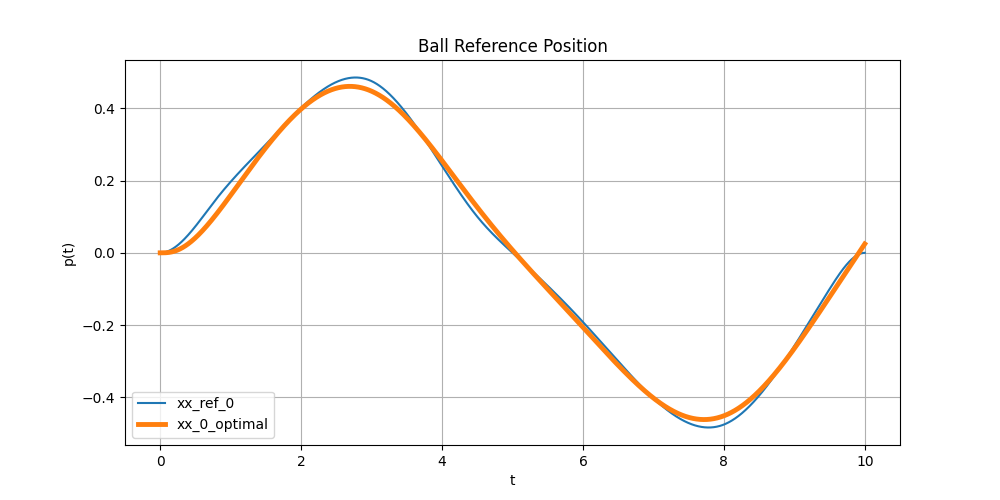

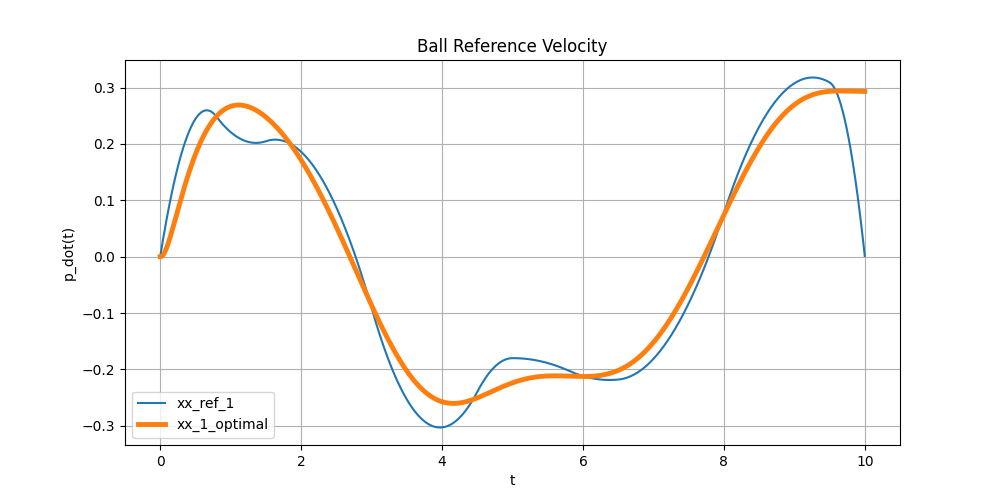

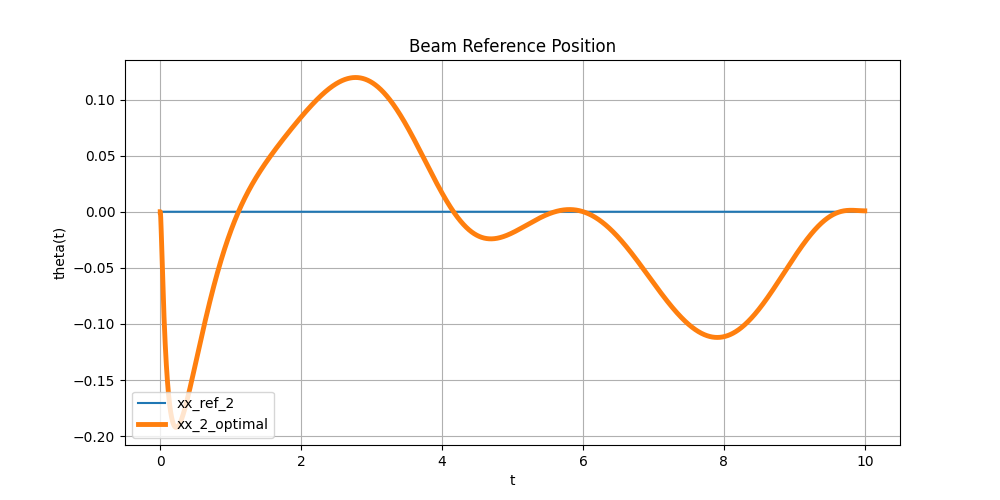

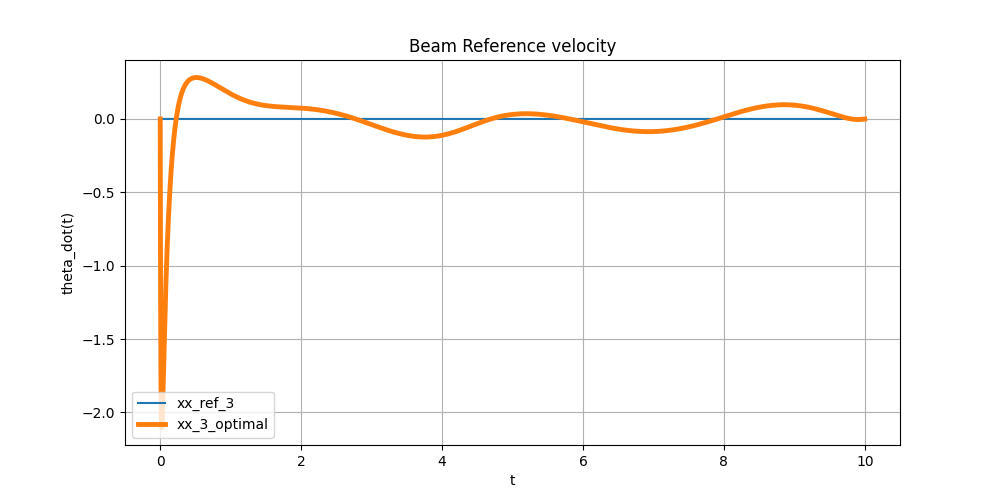

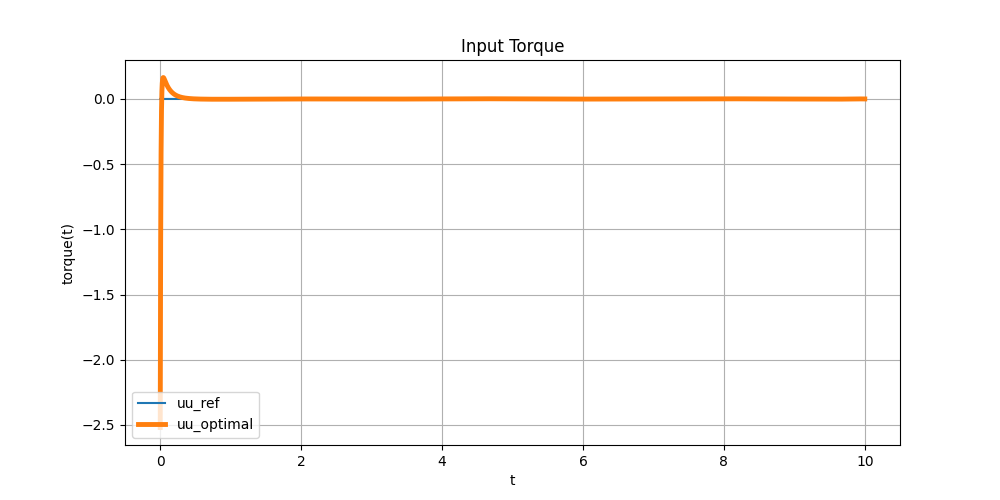

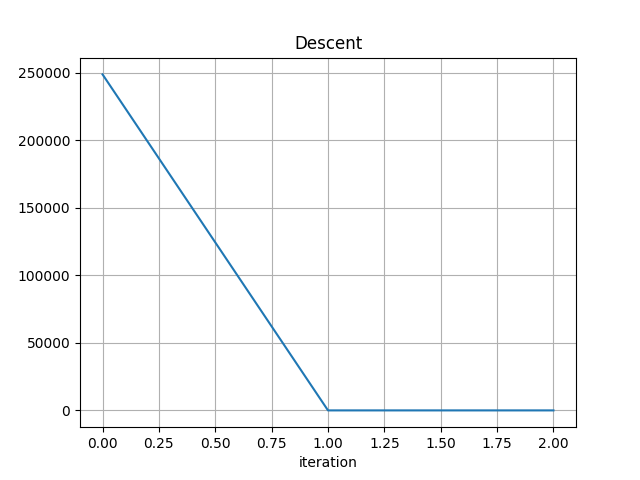

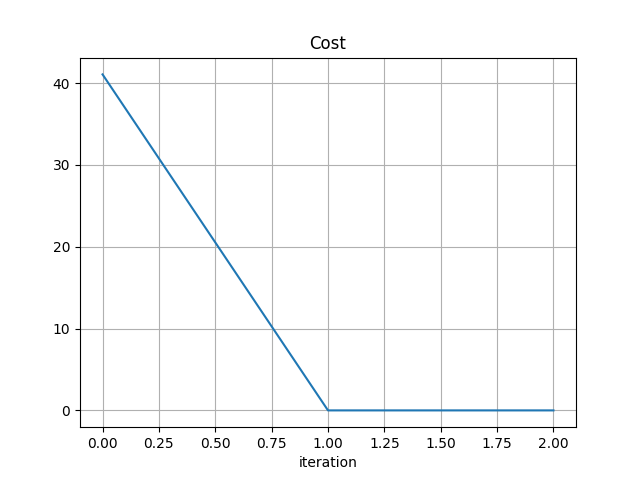

In [53]:
# Plotting the Graph
t = np.arange(0,params['tf'],params['dt'])
fig0, ax0 = plt_.subplots(figsize=(10, 5))
ax0.plot(t, xx_ref[0, :], '-', label='xx_ref_0')
ax0.plot(t, xx[0, :,Max_Iter], '-', label='xx_0_optimal',lw = 3.5)
ax0.legend(loc='lower left', ncol=1)
plt_.title("Ball Reference Position")
plt_.xlabel("t")
plt_.ylabel("p(t)")
plt_.grid()
plt_.show()
plt_.close(fig0)
plt_.savefig('plot/opt_traj_pos.jpg',transparent = True)        #save plot as images for report

# Plotting the Graph
fig1, ax1 = plt_.subplots(figsize=(10, 5))
ax1.plot(t, xx_ref[1, :], '-', label='xx_ref_1')
ax1.plot(t, xx[1, :,Max_Iter], '-', label='xx_1_optimal',lw = 3.5)
ax1.legend(loc='lower left', ncol=1)
plt_.title("Ball Reference Velocity")
plt_.xlabel("t")
plt_.ylabel("p_dot(t)")
plt_.grid()
plt_.show()
plt_.close(fig1)
plt_.savefig('plot/opt_traj_vel.jpg',transparent = True)        #save plot as images for report

# Plotting the Graph
fig2, ax2 = plt_.subplots(figsize=(10, 5))
ax2.plot(t, xx_ref[2, :], '-', label='xx_ref_2')
ax2.plot(t, xx[2, :,Max_Iter], '-', label='xx_2_optimal',lw = 3.5)
ax2.legend(loc='lower left', ncol=1)
plt_.title("Beam Reference Position")
plt_.xlabel("t")
plt_.ylabel("theta(t)")
plt_.grid()
plt_.show()
plt_.close(fig2)
plt_.savefig('plot/opt_traj_ang.jpg',transparent = True)       #save plot as images for report

# Plotting the Graph
fig3, ax3 = plt_.subplots(figsize=(10, 5))
ax3.plot(t, xx_ref[3, :], '-', label='xx_ref_3')
ax3.plot(t, xx[3, :,Max_Iter], '-', label='xx_3_optimal',lw = 3.5)
ax3.legend(loc='lower left', ncol=1)
plt_.title("Beam Reference velocity")
plt_.xlabel("t")
plt_.ylabel("theta_dot(t)")
plt_.grid()
plt_.show()
plt_.close(fig3)
plt_.savefig('plot/opt_traj_vang.jpg',transparent = True)        #save plot as images for report


# Plotting the Graph
fig, ax = plt_.subplots(figsize=(10, 5))
ax.plot(t, uu_ref[0, :], '-', label='uu_ref')
ax.plot(t, uu[0, :,Max_Iter], '-', label='uu_optimal', lw = 3.5)
ax.legend(loc='lower left', ncol=1)
plt_.title("Input Torque")
plt_.xlabel("t")
plt_.ylabel("torque(t)")
plt_.grid()
plt_.show()
plt_.close(fig)
plt_.savefig('plot/opt_inp.jpg',transparent = True)     #save plot as images for report

#plotting the descent
iter = range(0,Max_Iter+1)
plt_.plot(iter,np.abs(descent[0:Max_Iter+1,0]))
plt_.title('Descent')
plt_.xlabel('iteration')
plt_.grid()
plt_.show()
plt_.close()

#plotting the cost
iter = range(0,Max_Iter+1)
JJ = np.abs(np.dot((cost[0:Max_Iter+1,0]-cost[Max_Iter,0]),cost[Max_Iter,0]**(-1)))
plt_.plot(iter,JJ)
plt_.title('Cost')
plt_.xlabel('iteration')
plt_.grid()
plt_.show()
plt_.close()

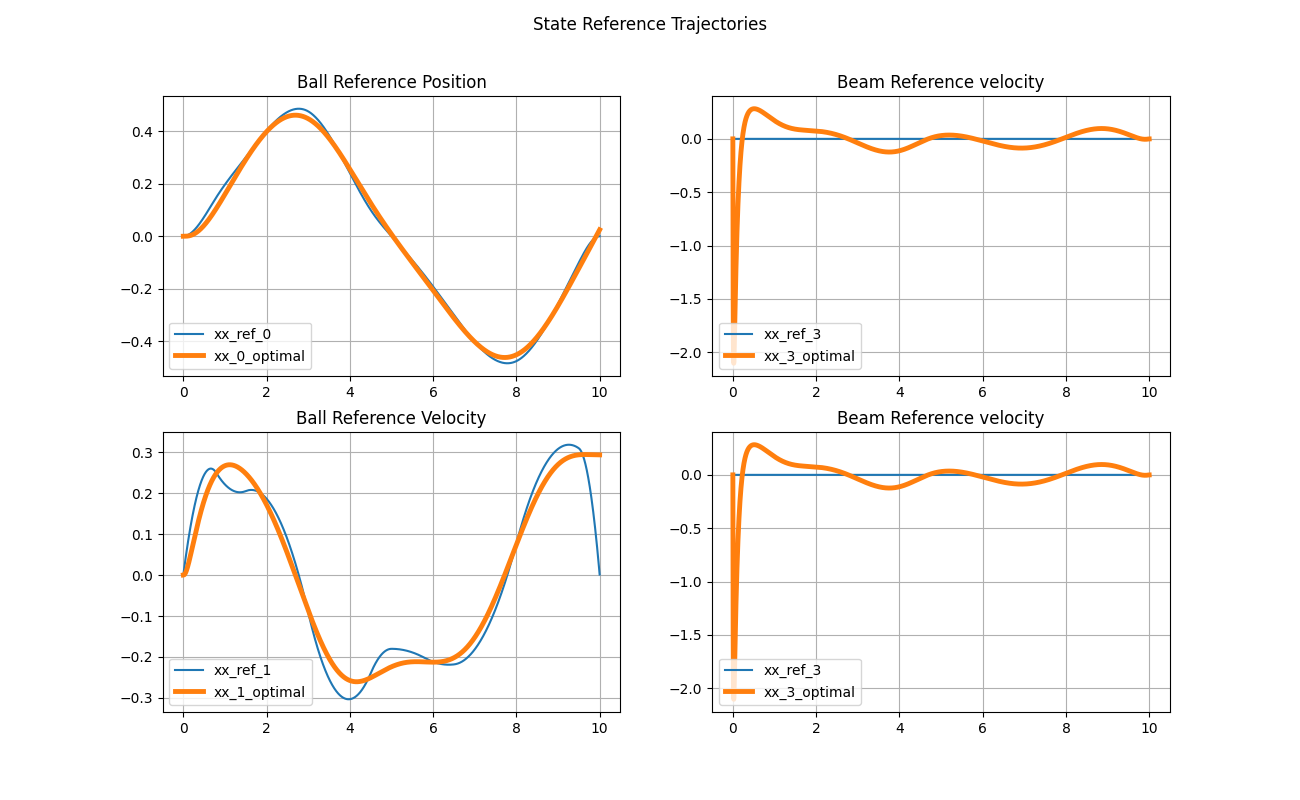

In [54]:
t = np.arange(0,params['tf'],params['dt'])
fig, axs = plt.subplots(2, 2, figsize=(13,8))
fig.suptitle('State Reference Trajectories')
#pos
axs[0,0].plot(t, xx_ref[0, :], '-', label='xx_ref_0')
axs[0,0].plot(t, xx[0, :,Max_Iter], '-', label='xx_0_optimal',lw = 3.5)
axs[0,0].legend(loc='lower left', ncol=1)
axs[0, 0].set_title("Ball Reference Position")
#vel
axs[1,0].plot(t, xx_ref[1, :], '-', label='xx_ref_1')
axs[1,0].plot(t, xx[1, :,Max_Iter], '-', label='xx_1_optimal',lw = 3.5)
axs[1,0].legend(loc='lower left', ncol=1)
axs[1, 0].sharex(axs[0, 0])
axs[1, 0].set_title("Ball Reference Velocity")
#beam pos
axs[0,1].plot(t, xx_ref[3, :], '-', label='xx_ref_3')
axs[0,1].plot(t, xx[3, :,Max_Iter], '-', label='xx_3_optimal',lw = 3.5)
axs[0,1].legend(loc='lower left', ncol=1)
axs[0,1].set_title("Beam Reference velocity")
#beam vel
axs[1,1].plot(t, xx_ref[3, :], '-', label='xx_ref_3')
axs[1,1].plot(t, xx[3, :,Max_Iter], '-', label='xx_3_optimal',lw = 3.5)
axs[1,1].legend(loc='lower left', ncol=1)
axs[1,1].set_title("Beam Reference velocity")
axs[1,1].sharex(axs[0,1])
axs[0,0].grid()
axs[0,1].grid()
axs[1,0].grid()
axs[1,1].grid()
plt_.show()
plt_.close(fig)
fig.savefig('plot/state_reference.jpg', transparent = True)

In [55]:
## TASK 3: tracking of the optimal trajectory
# Take the optimal trajectory computed in task 2
xx_opt = np.reshape(xx[:, :, Max_Iter:Max_Iter+1], (nx, TT))
uu_opt = np.reshape(uu[:, :, Max_Iter:Max_Iter+1], (nu, TT))
xx_init_noisy = np.array([[0.07,0.02,0.005,0]]).T
TotalCost= [0]

# Linearize the system about the feasible trajectory computed, compute LQ optimal controller and Track the generated optimal trajectory
xx_track, uu_track = opt.Trajectory_Tracking(xx_opt, uu_opt, xx_init_noisy, TT, params).values()

# Cost of the optimal control problem
for tt in range(0,TT-1):

    uu_track_tt = uu_track[:, tt:tt + 1] # shape (1,1)
    uu_opt_tt = uu_opt[:, tt:tt + 1] # shape (1,1)
    xx_track_tt = xx_track[:, tt:tt + 1]      # shape (4,1)
    xx_opt_tt = xx_opt[:, tt:tt + 1] # shape (4,1)

    cost_temp = cost_function.Stage_Cost(xx_track_tt, uu_track_tt, xx_opt_tt, uu_opt_tt, params)['cost_t'] # cost of the generated
    TotalCost[0] = TotalCost[0] + cost_temp[0]

xx_track_TT = xx_track[:,TT-1:TT]
xx_opt_TT = xx_opt[:,TT-1:TT]
cost_temp = cost_function.Terminal_Cost(xx_track_TT, xx_ref_TT,params)['cost_T']

TotalCost[0] = TotalCost[0] + cost_temp[0]

print('cost', TotalCost)


cost [1643.3548318147875]


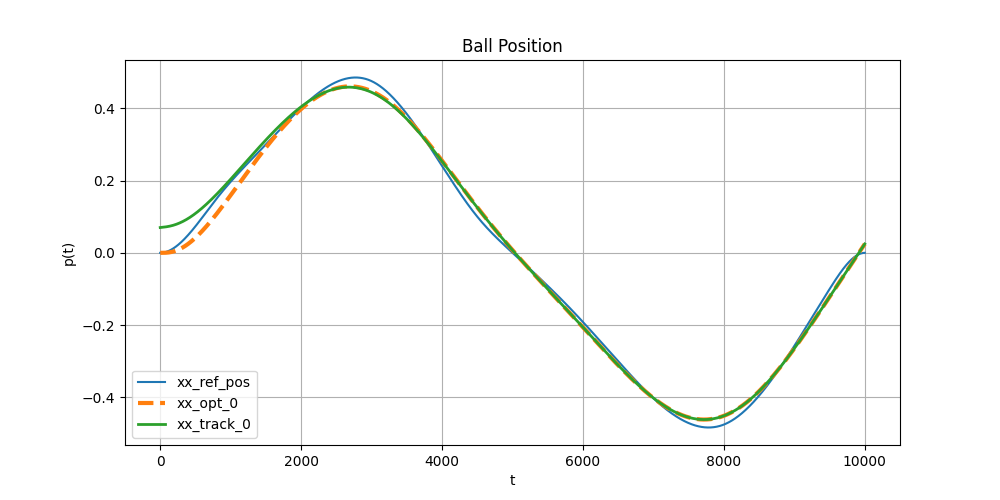

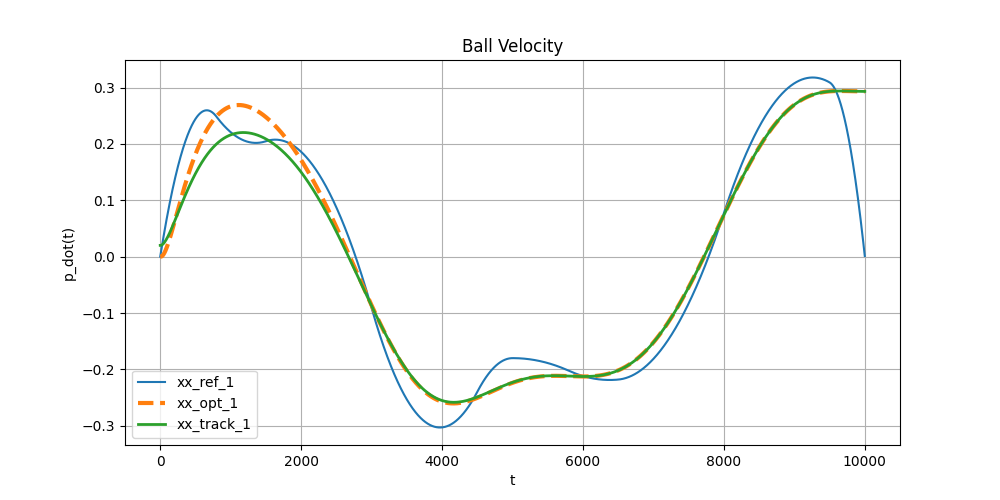

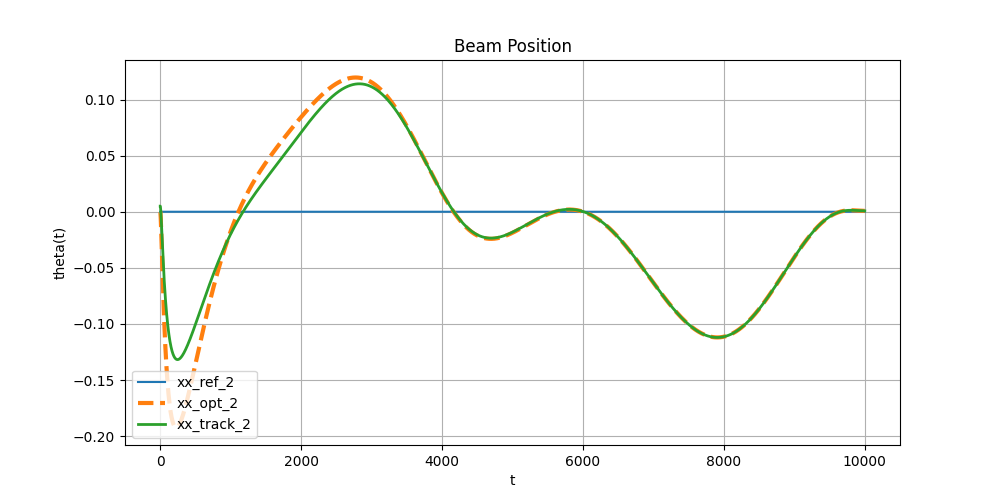

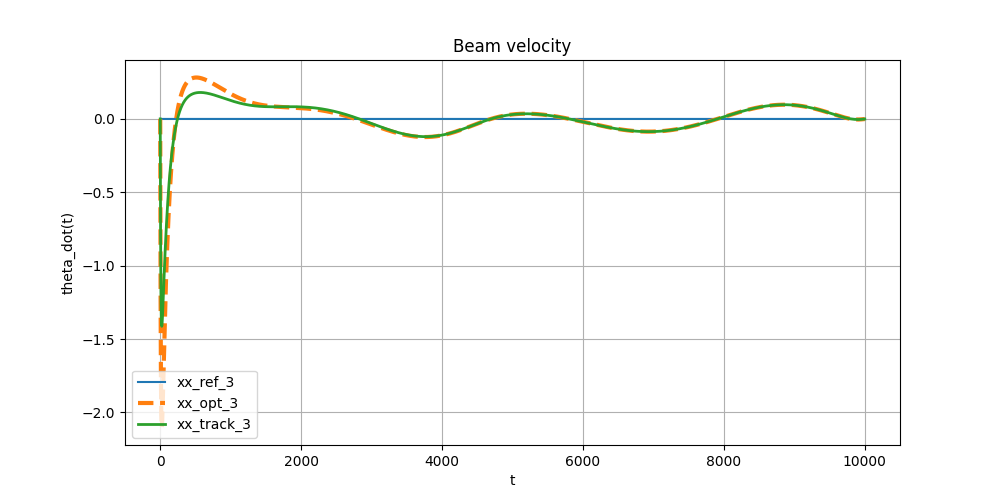

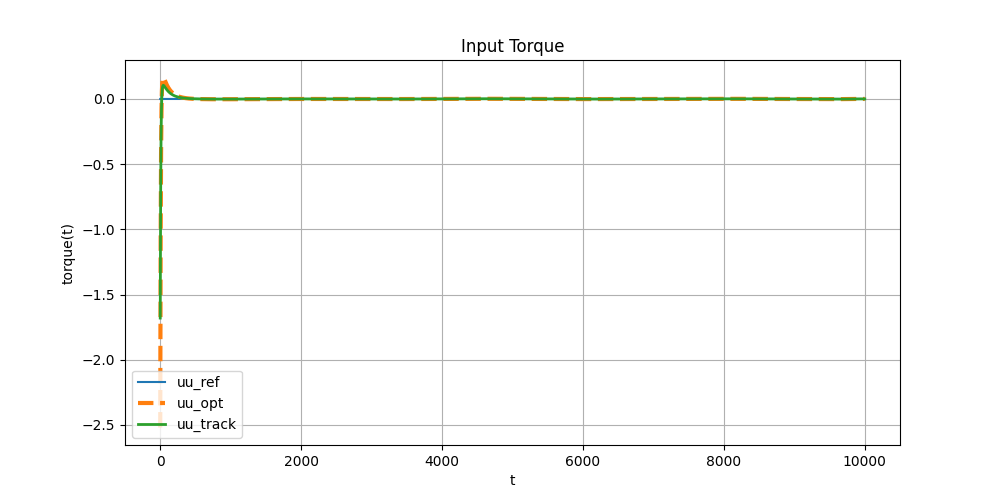

In [56]:
# Plotting the Graph
t = range(0,TT)
fig0, ax0 = plt_.subplots(figsize=(10, 5))
ax0.plot(t, xx_ref[0, :], '-', label='xx_ref_pos')
ax0.plot(t, xx[0, :,Max_Iter], '--', label='xx_opt_0',lw = 3)
ax0.plot(t, xx_track[0,:], '-', label = 'xx_track_0', lw=2)
ax0.legend(loc='lower left', ncol=1)
#plt_.ylim((0.3,0.31))
#plt_.xlim((0,3000))
plt_.title("Ball Position")
plt_.xlabel("t")
plt_.ylabel("p(t)")
plt_.grid()
plt_.show()
plt_.close(fig0)


# Plotting the Graph
t = range(0,TT)
fig1, ax1 = plt_.subplots(figsize=(10, 5))
ax1.plot(t, xx_ref[1, :], '-', label='xx_ref_1')
ax1.plot(t, xx[1, :,Max_Iter], '--', label='xx_opt_1',lw = 3)
ax1.plot(t, xx_track[1,:], '-', label = 'xx_track_1',lw = 2)
ax1.legend(loc='lower left', ncol=1)
plt_.title("Ball Velocity")
plt_.xlabel("t")
plt_.ylabel("p_dot(t)")
plt_.grid()
plt_.show()
plt_.close(fig1)




# Plotting the Graph
t = range(0,TT)
fig2, ax2 = plt_.subplots(figsize=(10, 5))
ax2.plot(t, xx_ref[2, :], '-', label='xx_ref_2')
ax2.plot(t, xx[2, :,Max_Iter], '--', label='xx_opt_2',lw = 3)
ax2.plot(t, xx_track[2,:], '-', label = 'xx_track_2',lw = 2)
ax2.legend(loc='lower left', ncol=1)
plt_.title("Beam Position")
plt_.xlabel("t")
plt_.ylabel("theta(t)")
plt_.grid()
plt_.show()
plt_.close(fig2)



# Plotting the Graph
t = range(0,TT)
fig3, ax3 = plt_.subplots(figsize=(10, 5))
ax3.plot(t, xx_ref[3, :], '-', label='xx_ref_3')
ax3.plot(t, xx[3, :,Max_Iter], '--', label='xx_opt_3',lw = 3)
ax3.plot(t, xx_track[3,:], '-', label = 'xx_track_3',lw = 2)
ax3.legend(loc='lower left', ncol=1)
plt_.title("Beam velocity")
plt_.xlabel("t")
plt_.ylabel("theta_dot(t)")
plt_.grid()
plt_.show()
plt_.close(fig3)



# Plotting the Graph
t = range(0,TT)
fig, ax = plt_.subplots(figsize=(10, 5))
ax.plot(t, uu_ref[0, :], '-', label='uu_ref')
ax.plot(t, uu[0, :,Max_Iter], '--', label='uu_opt',lw = 3)
ax.plot(t, uu_track[0,:], '-', label = 'uu_track',lw = 2)
ax.legend(loc='lower left', ncol=1)
plt_.title("Input Torque")
plt_.xlabel("t")
plt_.ylabel("torque(t)")
plt_.grid()
plt_.show()
plt_.close(fig)



#save plot as images for report#
fig.savefig('plot/track_torque.jpg',transparent = True)
fig0.savefig('plot/track_pos.jpg',transparent = True)
fig1.savefig('plot/track_vel.jpg',transparent = True)
fig2.savefig('plot/track_beam.jpg',transparent = True)
fig3.savefig('plot/track_beamV.jpg',transparent = True)

x_limit = params['LL']
y_limit = params['LL']
history_len = 500;
ball_rad = params['rr']
beam_len = params['LL']
frame_rate = params['dt']
theta = xx_track[2, :]
Xp    = xx_track[0, :]

visu.animate(x_limit,
                 y_limit,
                 history_len,
                 ball_rad,
                 beam_len,
                 frame_rate,
                 theta,
                 Xp )